In [1]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
    
import pandas as pd             
import seaborn as sns           
import sklearn  

# HR Analytics: Job Change of Data Scientists

В данной работе на основе данных сотрудников решается задача бинарной классификации: на основе различных факторов необходимо предсказать удовлетворен ли человек текущим местом работы или же находится в поиске нового, также необходимо выявить факторы, повлиявшие на решение работника. 

Датасет включает около 19200 записей и 14 признаков: 

1. enrollee_id - уникальный идентификатор сотрудника
2. city - код города
3. city_development_index - индекс качества жизни города
4. gender - пол
5. relevant_experience - опыт работы(на соответствующей должности); принимает два значения(опыт есть, опыта нет)
6. enrolled_university - информация об обучении в учебном заведении (не учится, учится на полной занятости, учится на частичной                                                                      занятости)
7. education_level - уровень оконченного образования
8. major_discipline - основная дисциплина при получении образования
9. experience - общий стаж работы
10. company_size - число сотрудников в текущей компании(задается диапазон)
11. company_type - тип компании
12. last_new_job - число лет работы в предыдущей компании(never, если не меняли компанию)
13. training_hours - часы, потраченные на обучение
14. target - 0 - сотрудник не ищет новую работу, 1 - сотрудник ищет новую работу

# Загрузка и чтение данных

In [2]:
url = "aug_train.csv"
data_raw = pd.read_csv(url)

Размер таблицы данных составляет: 

In [3]:
data_raw.shape

(19158, 14)

In [4]:
data_raw.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Таблица содержит 10 категориальных признаков и 4 числовых признака:

In [5]:
categorical_columns = [c for c in data_raw.columns if data_raw[c].dtype.name == 'object']
binary_columns = [c for c in data_raw.columns if data_raw[c].dtype.name == 'bool']
numerical_columns   =  [c for c in data_raw.columns  if data_raw[c].dtype.name != 'object' and data_raw[c].dtype.name != 'bool']

print(categorical_columns)
print(binary_columns)
print(numerical_columns)

['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
[]
['enrollee_id', 'city_development_index', 'training_hours', 'target']


In [6]:
data_raw = data_raw.drop(['enrollee_id'], axis = 1)
numerical_columns.remove('enrollee_id')

Рассмотрим, какие значения принимают категориальные признаки. В дальнейшем эта информация понадобится для их обработки. 

In [7]:
for i in categorical_columns:
    print("Unique values of attribute " + i + " are:")
    print(data_raw[i].unique())
    print("\n")

Unique values of attribute city are:
['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'cit

# Обработка категориальных признаков

Заменим тип Object на тип, предназначенный для хранения категориальных значений(векторизация проводится позже)

In [8]:
for i in data_raw.columns:
    if data_raw[i].dtype.name == 'object':
        data_raw[i] = data_raw[i].astype('category')
categorical_columns = [i for i in data_raw.columns if data_raw[i].dtype.name == 'category']

# Визуализация данных и описательная статистика

Ниже приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей для числовых признаков.

In [9]:
data_raw.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


In [10]:
data_raw.describe(include=['category'])

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


Из двух таблиц выше видим, что большинство сотрудников - мужчины, у большинства работников есть релевантный опыт. 

Опрашиваемые, в основном, закончили ВУЗ, а их основной дисциплиной являлись математические и компьютерные науки (STEM). На текущий момент большинство не обучаются в Университете (no enrollment). Интересно, что опыт (полученный на любой должности) основной массы составляет больше 20 лет. 

Большинство анализируемых компаний - небольшого размера (от 50 до 100 сотрудников)  и являются обществами с ограниченной ответственностью (Pvt Ltd). Информация собиралась с сотрудников из 123-х городов, чей средний индекс развития превышает 0,8. 

В среднем сотрудники потратили на прохождение тренингов 65 часов. Работники, которые не проходили тренинги, отсутствуют. "Рекорд" по времени просмотренных тренингов - 336 часов. 

Посмотрим визуальное соотношение значений категориальных признаков, используя гистограммы. Перед гистограммой выведем процентное соотношение.

Male - 90.25%
Female - 8.45%
Other - 1.3%


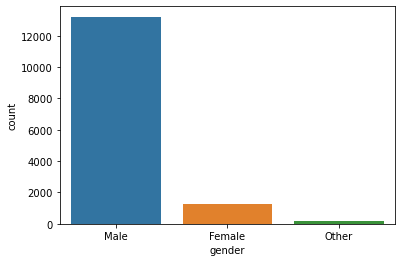

In [11]:
valueCounts = data_raw.gender.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.gender.count()))) + "%")
sns.countplot(x = 'gender',order = valueCounts.index, data = data_raw)
pass

Has relevent experience - 71.99%
No relevent experience - 28.01%


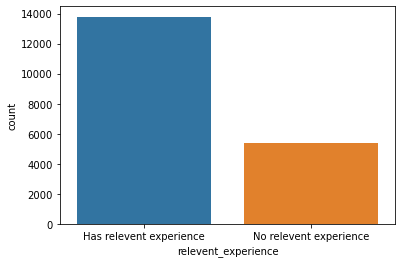

In [12]:
valueCounts = data_raw.relevent_experience.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.relevent_experience.count()))) + "%")
sns.countplot(x='relevent_experience',order=valueCounts.index, data=data_raw)
pass

no_enrollment - 73.6%
Full time course - 20.01%
Part time course - 6.38%


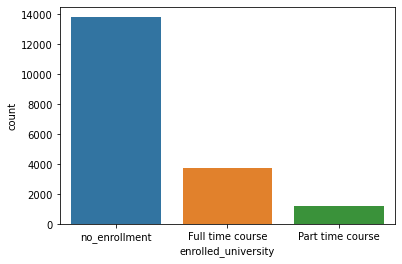

In [13]:
valueCounts = data_raw.enrolled_university.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.enrolled_university.count()))) + "%")
sns.countplot(x='enrolled_university',order=valueCounts.index, data=data_raw)
pass

Graduate - 62.03%
Masters - 23.32%
High School - 10.79%
Phd - 2.21%
Primary School - 1.65%


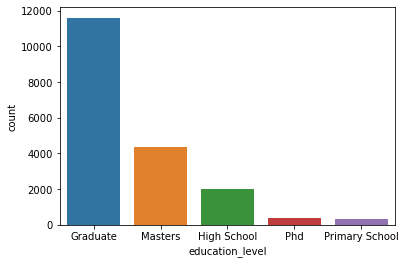

In [14]:
valueCounts = data_raw.education_level.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.education_level.count()))) + "%")
sns.countplot(x='education_level',order=valueCounts.index, data=data_raw)
pass

STEM - 88.66%
Humanities - 4.09%
Other - 2.33%
Business Degree - 2.0%
Arts - 1.55%
No Major - 1.36%


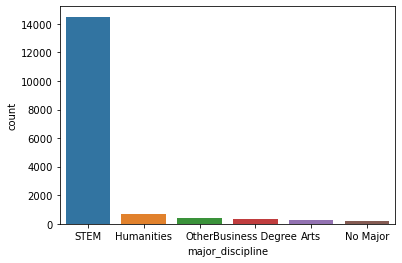

In [15]:
valueCounts = data_raw.major_discipline.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.major_discipline.count()))) + "%")
sns.countplot(x='major_discipline',order=valueCounts.index, data=data_raw)
pass

>20 - 17.21%
5 - 7.49%
4 - 7.35%
3 - 7.09%
6 - 6.37%
2 - 5.9%
7 - 5.38%
10 - 5.16%
9 - 5.13%
8 - 4.2%
15 - 3.59%
11 - 3.48%
14 - 3.07%
1 - 2.88%
<1 - 2.73%
16 - 2.66%
12 - 2.59%
13 - 2.09%
17 - 1.79%
19 - 1.59%
18 - 1.47%
20 - 0.78%


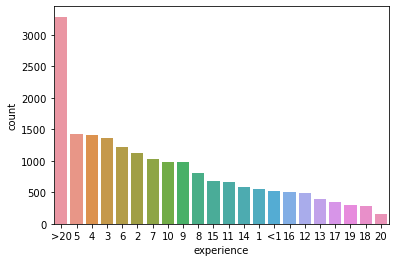

In [16]:
valueCounts = data_raw.experience.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.experience.count()))) + "%")
sns.countplot(x='experience',order=data_raw['experience'].value_counts().index, data=data_raw)
pass

50-99 - 23.32%
100-500 - 19.45%
10000+ - 15.27%
10/49 - 11.13%
1000-4999 - 10.05%
<10 - 9.89%
500-999 - 6.63%
5000-9999 - 4.26%


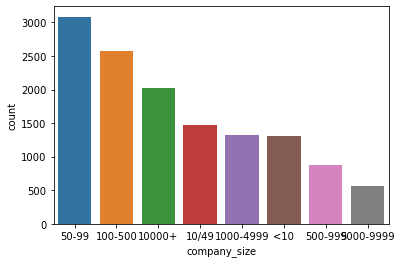

In [17]:
valueCounts = data_raw.company_size.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.company_size.count()))) + "%")
sns.countplot(x='company_size',order=valueCounts.index, data=data_raw)
pass

Pvt Ltd - 75.41%
Funded Startup - 7.69%
Public Sector - 7.34%
Early Stage Startup - 4.63%
NGO - 4.0%
Other - 0.93%


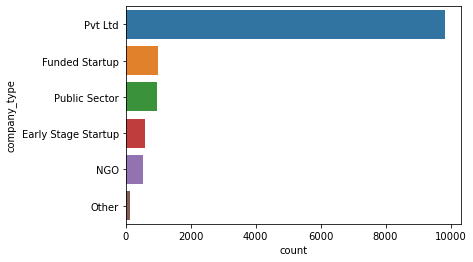

In [18]:
valueCounts = data_raw.company_type.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.company_type.count()))) + "%")
sns.countplot(y='company_type',order=valueCounts.index, data=data_raw)
pass

1 - 42.91%
>4 - 17.56%
2 - 15.48%
never - 13.09%
4 - 5.49%
3 - 5.47%


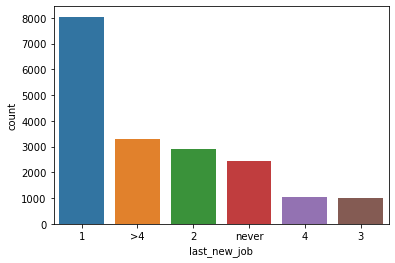

In [19]:
valueCounts = data_raw.last_new_job.value_counts()
for attr, value in valueCounts.items():
    print(attr + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.last_new_job.count()))) + "%")
sns.countplot(x='last_new_job',order=valueCounts.index, data=data_raw)
pass

Теперь посмотрим на процентное соотношение целевой колонки target. Видим, что классы несбалансированны. 

0.0 - 75.07%
1.0 - 24.93%


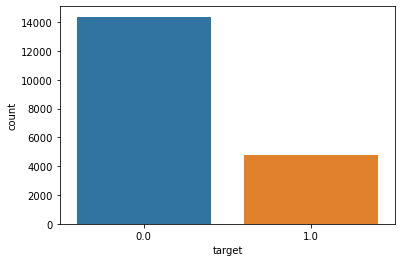

In [20]:
valueCounts = data_raw.target.value_counts()
for attr, value in valueCounts.items():
    print(str(attr) + " - " + str(float('{:.2f}'.format(value * 100 / data_raw.target.count()))) + "%")
sns.countplot(x='target',order=valueCounts.index, data=data_raw)
pass

Посмотрим на часототу для числовых признаков:

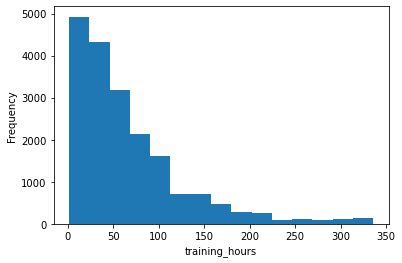

In [21]:
plt.hist(data_raw["training_hours"], bins = 15)
plt.xlabel('training_hours')
plt.ylabel("Frequency")
plt.show()

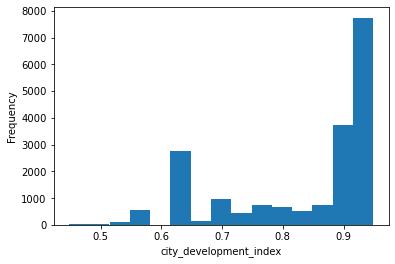

In [22]:
plt.hist(data_raw["city_development_index"], bins = 15)
plt.xlabel('city_development_index')
plt.ylabel("Frequency")
plt.show()

Далее видим, что признак training_hours содержит выбросы:

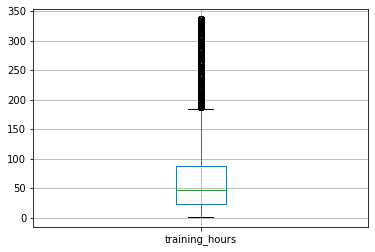

In [23]:
data_raw[['training_hours']].boxplot()

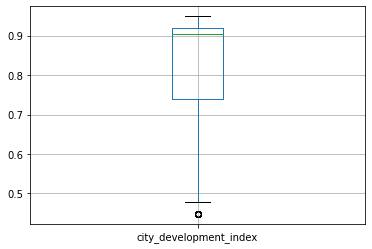

In [24]:
data_raw[['city_development_index']].boxplot()

Корреляционная матрица отражает степень связи между признаками:

In [25]:
corr_mat = data_raw.corr()
corr_mat

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


Матрица корреляции в графическом виде:

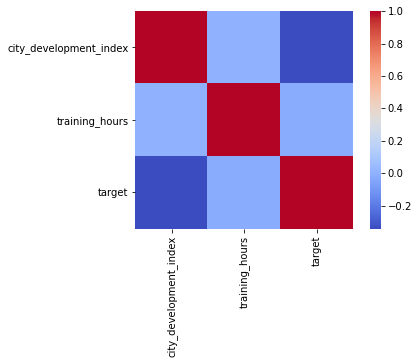

In [26]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

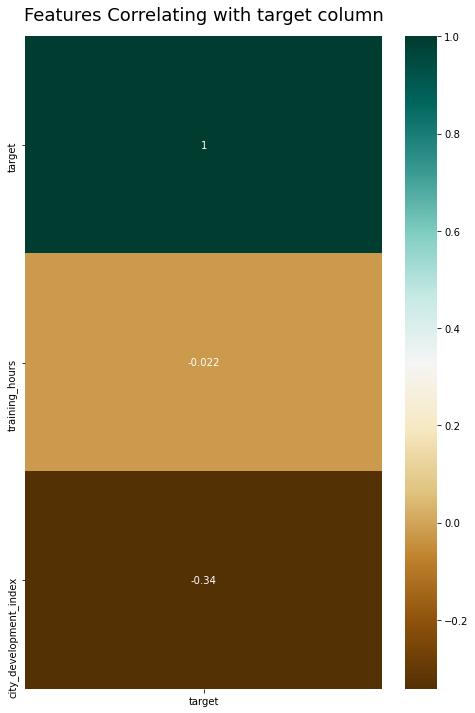

In [27]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data_raw.corr()[['target']].sort_values(by='target', ascending=False), annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with target column', fontdict={'fontsize':18}, pad=16);

Видим, что сильной связи между целевым признаком и признаками 'Индекс развития города', 'Часы, потраченные на тренинги' не наблюдается. Влияние пройденных тренингов на решение об уходе из компании практически отсутствует. Также не влияет на время, потраченное на тренинги, индекс развития городской среды. 

Построим диаграммы рассеивания для каждой пары признаков:

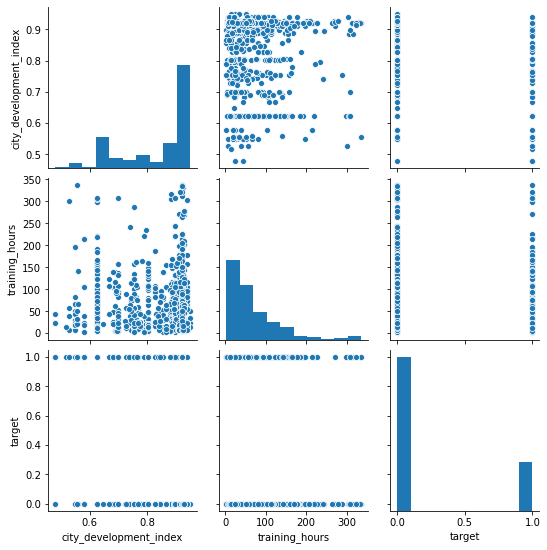

In [28]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data_raw.shape[0]), size=1000, replace=False)
sns.pairplot(data_raw.iloc[random_subset], diag_kind='hist')
pass

Вывод: нет сильно коррелированных признаков, не требуется убирать признаки.

In [29]:
pd.crosstab(data_raw['gender'], data_raw['target'], margins=True, margins_name="Total")

target,0.0,1.0,Total
gender,,,
Female,912,326,1238
Male,10209,3012,13221
Other,141,50,191
Total,11262,3388,14650


Процент мужчин и женщин, сделавших выбор в пользу смены работы, практически совпадает (24.8% vs 26.3%)

In [30]:
pd.crosstab(data_raw['relevent_experience'], data_raw['target'], margins=True, margins_name="Total")

target,0.0,1.0,Total
relevent_experience,,,
Has relevent experience,10831,2961,13792
No relevent experience,3550,1816,5366
Total,14381,4777,19158


Процент людей, желающих сменить работу, среди работников, имеющих релевантный опыт, выше(33% vs 21%)

In [31]:
pd.crosstab(data_raw['education_level'], data_raw['target'], margins=True, margins_name="Total")

target,0.0,1.0,Total
education_level,,,
Graduate,8353,3245,11598
High School,1623,394,2017
Masters,3426,935,4361
Phd,356,58,414
Primary School,267,41,308
Total,14025,4673,18698


Магистры чаще хотят сменить место работы, чем, к примеру, бакалавры. 

In [32]:
pd.crosstab(data_raw['company_size'], data_raw['target'], margins=True, margins_name="Total")

target,0.0,1.0,Total
company_size,,,
10/49,1127,344,1471
100-500,2156,415,2571
1000-4999,1128,200,1328
10000+,1634,385,2019
50-99,2538,545,3083
500-999,725,152,877
5000-9999,461,102,563
<10,1084,224,1308
Total,10853,2367,13220


Чаще всего о смене компании задумываются в небольших предприятиях численностью от 50 до 100 человек. 

In [33]:
pd.crosstab(data_raw['last_new_job'], data_raw['target'], margins=True, margins_name="Total")

target,0.0,1.0,Total
last_new_job,,,
1,5915,2125,8040
2,2200,700,2900
3,793,231,1024
4,801,228,1029
>4,2690,600,3290
never,1713,739,2452
Total,14112,4623,18735


Наибольший процент желающих сменить работу - среди тех, кто этого никогда не делал. 

# Обработка пропущенных значений

Выясним, какие признаки имеют пропущенные значения, а также их процентное соотношение

In [34]:
nanValuesStatistics = pd.DataFrame({'Nan values count': data_raw.isnull().sum(), 
                                    '%': data_raw.isnull().sum()/data_raw.shape[0] * 100})
nanValuesStatistics

,Nan values count,%
city,0,0.000000
city_development_index,0,0.000000
gender,4508,23.530640
relevent_experience,0,0.000000
enrolled_university,386,2.014824
education_level,460,2.401086
major_discipline,2813,14.683161
experience,65,0.339284
company_size,5938,30.994885
company_type,6140,32.049274


Признаки, имеющие пропущенные значения - категориальные, заполним их значением моды.

In [35]:
for attr in nanValuesStatistics.index:
    data_raw[attr].fillna(data_raw[attr].mode().iloc[0], inplace=True)
data_raw.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

# Обработка категориальных признаков - 2

Обработаем категориальные признаки. Для этого выедилим среди них бинарные и небинарные признаки. Бинарные признаки закодируем 0 и 1. А небинарные векторизуем, то есть вместо признака, принимающего n значений, добавим n признаков, которые будут принимать значения 0 или 1, в зависимости от значения исходного признака. Например, признак enrolled_university принимает 3 различных значения. Если сотрудник проходит 'part_time_course', то новый признак 'part_time_course' = 1, остальные 2 признакf принимают значение 0.

In [36]:
data_statistics = data_raw.describe(include=['category'])
binary_columns    = [c for c in categorical_columns if data_statistics[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_statistics[c]['unique'] > 2]
print("Бинарные признаки ")
print(binary_columns)
print("\n")
print("Небинарные признаки ")
nonbinary_columns


Бинарные признаки 
['relevent_experience']


Небинарные признаки 


['city',
 'gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [37]:
for i in binary_columns:
    data_raw[i] = data_raw[i].cat.codes

Отдельно обработаем признак 'city'. Так как в каждом значении присутствует код города, то нетрудно сделать этот признак числовым. 

In [38]:
data_raw['city'] = data_raw['city'].str.replace('city_', "")
data_raw['city'] = data_raw['city'].astype(int)
nonbinary_columns.remove('city')

In [39]:
data_raw['gender'] = data_raw['gender'].str.replace('Other', "gender_other")
data_raw['major_discipline'] = data_raw['major_discipline'].str.replace('Other', "major_discipline_other")
data_raw['company_type'] = data_raw['company_type'].str.replace('Other', "company_type_other")
for i in nonbinary_columns:
    data_raw = pd.concat((data_raw, pd.get_dummies(data_raw[i])), axis = 1)
data_raw.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,...,NGO,Public Sector,Pvt Ltd,company_type_other,1,2,3,4,>4,never
0,103,0.920,Male,0,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,...,0,0,1,0,1,0,0,0,0,0
1,40,0.776,Male,1,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,...,0,0,1,0,0,0,0,0,1,0
2,21,0.624,Male,1,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,...,0,0,1,0,0,0,0,0,0,1
3,115,0.789,Male,1,no_enrollment,Graduate,Business Degree,<1,50-99,Pvt Ltd,...,0,0,1,0,0,0,0,0,0,1
4,162,0.767,Male,0,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,...,0,0,0,0,0,0,0,1,0,0


In [40]:
data = data_raw.drop(nonbinary_columns, axis = 1)
data.shape

(19158, 64)

# Нормализация количественных признаков

Исключим влияние масштаба и диапазона данных на целевой признак, для этого нормализуем количественные признаки с помощью стандартизации.

In [41]:
numerical_columns.remove('target')

In [42]:
data_norm = (data[numerical_columns] - data[numerical_columns].mean(axis = 0))/data[numerical_columns].std(axis = 0)
data_norm.head()

,city_development_index,training_hours
0,0.738900,-0.488972
1,-0.428399,-0.305817
2,-1.660547,0.293599
3,-0.323017,-0.222565
4,-0.501355,-0.955184


In [43]:
data_norm = pd.concat((data_norm, data.drop(numerical_columns, axis = 1)), axis = 1)
data_norm.head()

,city_development_index,training_hours,city,relevent_experience,target,Female,Male,gender_other,Full time course,Part time course,...,NGO,Public Sector,Pvt Ltd,company_type_other,1,2,3,4,>4,never
0,0.738900,-0.488972,103,0,1.0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,-0.428399,-0.305817,40,1,0.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,-1.660547,0.293599,21,1,0.0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,-0.323017,-0.222565,115,1,1.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,-0.501355,-0.955184,162,0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Обучающая и тестовая выборки

In [44]:
X = data_norm.drop('target', axis = 1)
y = data['target']
X = X.to_numpy()
y = y.to_numpy()

print(X.shape)
print(y.shape)

(19158, 63)
(19158,)


75% данных - обучающая выборка, 25% - тестовая выборка

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

14368 4790


# Классификатор ближайших соседей

Для обучения будем использовать k-Nearest Neighbourhood. Ниже приведена функция, обучающая модель и вычисляющая ошибки. 

In [46]:
from sklearn.neighbors import KNeighborsClassifier

for k in range (1, 10):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_predict = knn.predict(X_test)
    err_train = np.mean(y_train != y_train_pred)
    err_test  = np.mean(y_test  != y_test_predict)
    print("k = {}, err_train = {}, err_test = {}".format(k, err_train, err_test))

k = 1, err_train = 0.0020879732739420937, err_test = 0.30020876826722337
k = 2, err_train = 0.13898942093541203, err_test = 0.24592901878914405
k = 3, err_train = 0.1428869710467706, err_test = 0.26534446764091857
k = 4, err_train = 0.1696826280623608, err_test = 0.24926931106471817
k = 5, err_train = 0.17107461024498885, err_test = 0.2561586638830898
k = 6, err_train = 0.18151447661469933, err_test = 0.24697286012526096
k = 7, err_train = 0.18422884187082406, err_test = 0.25281837160751564
k = 8, err_train = 0.19063195991091314, err_test = 0.24279749478079332
k = 9, err_train = 0.1916759465478842, err_test = 0.24572025052192067


Наименьшее значение ошибки на обучающей выборке - 0,2%, достигается при k = 1. Наименьшее значение ошибки на тестовой выборке - 24,2%, достигается при k = 8. Результаты не очень хорошие. Попробуем побороться с несбалансированностью классов. 

# Борьба с несбалансированностью

Ранее уже было показано, что целевой класс target несбалансирован(75% vs 25%). 

Один из подходов к решению - продублировать класс с меньшим количеством значений(в нашем случае: 1 - сотрудник ищет новую работу), в результате соотношение классов должно выровняться. Однако это не добавит в модель новой информации. 

Попробуем применить алгоритм SMOTE(Synthetic Minority Oversampling Technique), синтезирующий новые примеры. 

In [47]:
from imblearn.over_sampling import SMOTE

svm_smote = SMOTE( random_state=42,k_neighbors=3)
X_smote, y_smote = svm_smote.fit_resample(X, y)

X_train_smote, X_test_smote, Y_train_smote, Y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.25, random_state = 42)

In [48]:
df = pd.DataFrame(y_smote, columns = ['target'])

0.0 - 50.0%
1.0 - 50.0%


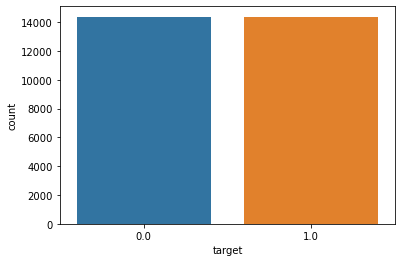

In [49]:
valueCounts = df.target.value_counts()
for attr, value in valueCounts.items():
    print(str(attr) + " - " + str(float('{:.2f}'.format(value * 100 / df.target.count()))) + "%")
sns.countplot(x='target',order=valueCounts.index, data=df)
pass

Снова запустим классификатор ближайших соседей

In [50]:
for k in range (1, 10):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train_smote, Y_train_smote)
    y_train_pred_smote = knn.predict(X_train_smote)
    y_test_predict_smote = knn.predict(X_test_smote)
    err_train_smote = np.mean(Y_train_smote != y_train_pred_smote)
    err_test_smote  = np.mean(Y_test_smote  != y_test_predict_smote)
    print("k = {}, err_train = {}, err_test = {}".format(k, err_train_smote, err_test_smote))

k = 1, err_train = 0.0013907561077372399, err_test = 0.19538311778612155
k = 2, err_train = 0.03662324417041398, err_test = 0.2062300097343902
k = 3, err_train = 0.13379073756432247, err_test = 0.23334723960506187
k = 4, err_train = 0.12702239117333458, err_test = 0.22750660547907106
k = 5, err_train = 0.18269899401974873, err_test = 0.25796134056459463
k = 6, err_train = 0.17110935978860506, err_test = 0.23765818384091225
k = 7, err_train = 0.20722266005284873, err_test = 0.2590738423028786
k = 8, err_train = 0.19730193315098976, err_test = 0.2493394520928939
k = 9, err_train = 0.2237262991979973, err_test = 0.26282853566958697


Ошибка на тестовой выборке уменьшилась и достигла 19,5% при k = 1. Результаты улучшились(по сравнению с результатами без применения балансировки) приблизительно на 5%, однако по-прежнему ошибка достаточно велика. 

# RF – случайный лес

Попробуем обучить модель другим методом - дерево решений, число деревьев выберем равное 100.

In [51]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train_smote, Y_train_smote)

err_train = np.mean(Y_train_smote != rf.predict(X_train_smote))
err_test  = np.mean(Y_test_smote  != rf.predict(X_test_smote))

print(err_train, err_test)

0.0013443975708126651 0.15491586705604227


По сравнению с предыдущим классификатором ошибка на тестовой выборке уменьшилась приблизительно на 4%, до 15.6.

# SVC - метод опорных векторов

In [52]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train_smote, Y_train_smote)

err_train = np.mean(Y_train_smote != svc.predict(X_train_smote))
err_test  = np.mean(Y_test_smote  != svc.predict(X_test_smote))

print(err_train, err_test)

0.2473691530295304 0.2522597691558893


Метод опорных векторов показал наихудший результат. 

# Вывод

Была рассмотрена задача бинарной классификации. Исходные данные содержали около 19200 записей, которые были визуализированы и предобработаны. При использовании алгоритма K-ближайших соседей ошибка на тестовой выборке составила 19.5%. Ошибка достаточно большая, но изменением параметра метода не удалось добиться значительного ее уменьшения. Борьба с несбалансированностью привела к снижению первоначальной ошибки на 5%. В качестве сравнения был использован алгоритм, использующий дерево решений, с ним ошибка составила около 15.6%, а также метод опорных векторов с ошибкой 25%. 

Таким образом, наименьшая полученная ошибка на обучающей выборке - 0,13%, на тестовой - 15.6%. 

# Обучение нейронной сети

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Зафиксируем количество нейронов на скрытом слое равным 100 и подберем гиперпараметр alpha. Затем нарисуем график зависимости между величиной ошибки и параметром alpha. Аналогичный график построим для точности. 

In [54]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
test_acc = []
train_acc = []

for alpha in alpha_arr :
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'adam', activation = 'relu', max_iter=100000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print("Минимальное значение ошибки на обучающей и тестовой выборках:")
print(min_train_err, min_test_err)
    
alpha_opt = alpha_arr[test_err == min_test_err]
print("Оптимальное значение параметра:" + str(alpha_opt[0]))
    

Минимальное значение ошибки на обучающей и тестовой выборках:
0.1651586859688196 0.22505219206680585
Оптимальное значение параметра:1.7782794100389228


Минимальное значение ошибки на тестовой выборке было достигнуто при alpha = 1.778. Ошибка при этом составила 22.5%. 
Примем значение alpha, на котором был достигнут минимум ошибки на тестовой выборке, за оптимальное. 

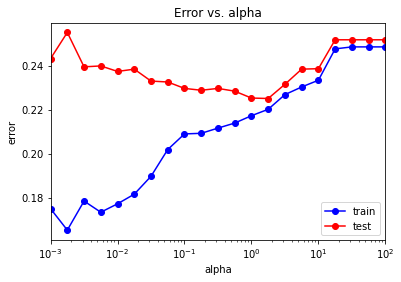

In [55]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

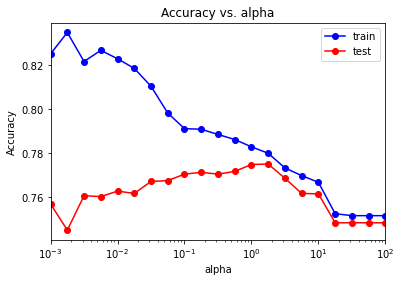

In [56]:
plt.semilogx(alpha_arr, train_acc, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

По графикам видим, что для обучающей выборки небольшого значения ошибки можно добиться при alpha близком к 0.001. Для тестовой же выборки это приводит к большим значениям ошибки. То есть при параметре, приблизительно меньшем 0.01 наблюдается переобучение. При alpha ~ > 2 величина ошибки начинает возрастать как на тестовой, так и на обучающей выборках. Скорее всего, нет смысла его далее увеличивать. 

Зафиксируем параметр alpha и попробуем уменьшить ошибку путем подбора количества нейронов на скрытом слое. 

In [57]:
n_array = np.linspace(1, 120, 120)
n_array = n_array.astype(int)
test_err = []
train_err = []
test_acc = []
train_acc = []

for n in n_array:
  mlp_model = MLPClassifier(alpha = alpha_opt[0], 
                            hidden_layer_sizes = (n,),
                            solver = 'adam', 
                            max_iter=10000,
                            activation = 'relu',
                            random_state = 42)
  mlp_model.fit(X_train, y_train)
  y_train_pred = mlp_model.predict(X_train) 
  y_test_pred = mlp_model.predict(X_test)
  train_err.append(np.mean(y_train != y_train_pred))
  test_err.append(np.mean(y_test != y_test_pred))
  train_acc.append(accuracy_score(y_train, y_train_pred))
  test_acc.append(accuracy_score(y_test, y_test_pred))

In [58]:
print("Минимальное значение ошибки на обучающей выборке достигнуто при количестве нейронов: " + str(n_array[np.argmin(train_err)]))
print(np.min(train_err))

print("Минимальное значение ошибки на тестовой выборке достигнуто при количестве нейронов: " + str(n_array[np.argmin(test_err)]))
print(np.min(test_err))

Минимальное значение ошибки на обучающей выборке достигнуто при количестве нейронов: 79
0.2165228285077951
Минимальное значение ошибки на тестовой выборке достигнуто при количестве нейронов: 107
0.22275574112734864


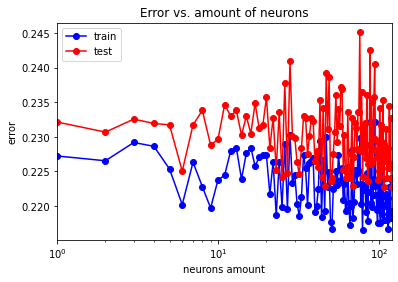

In [59]:
plt.semilogx(n_array, train_err, 'b-o', label = 'train')
plt.semilogx(n_array, test_err, 'r-o', label = 'test')
plt.xlim([np.min(n_array), np.max(n_array)])
plt.title('Error vs. amount of neurons')
plt.xlabel('neurons amount')
plt.ylabel('error')
plt.legend()

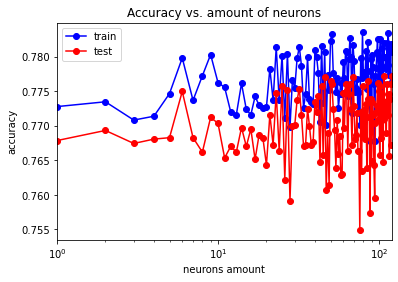

In [60]:
plt.semilogx(n_array, train_acc, 'b-o', label = 'train')
plt.semilogx(n_array, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(n_array), np.max(n_array)])
plt.title('Accuracy vs. amount of neurons')
plt.xlabel('neurons amount')
plt.ylabel('accuracy')
plt.legend()

Для тестовой выборки оптимальное количество нейронов оказалось равным 107. Ошибка на тестовой выборке составила 22.3 %, на обучающей - 21.6. 

# Вывод

Используя MLP-классификатор, не удалось добиться существенного уменьшения ошибки. Модель недообучается. Можно предположить, что 
эксперимент с количеством скрытых слоев может привести к улучшению результата. 